# 4.8 数值稳定性和模型初始化
- **目录**
  - 4.8.1 梯度消失和梯度爆炸
    - 4.8.1.1 梯度消失
    - 4.8.1.2 梯度爆炸
    - 4.8.1.3 打破对称性
  - 4.8.2 参数初始化
    - 4.8.2.1 默认初始化
    - 4.8.2.2 Xavier初始化

- 初始化方案的选择在神经网络学习中起着举足轻重的作用，它对保持数值稳定性至关重要。
- 这些初始化方案的选择可以与非线性激活函数的选择有趣的结合在一起。
- 选择哪个函数以及如何初始化参数可以决定优化算法收敛的速度有多快。
- 糟糕选择可能会导致我们在训练时遇到**梯度爆炸**或**梯度消失**。
- 本节更详细地探讨这些主题，并讨论一些有用的启发式方法。

## 4.8.1 梯度消失和梯度爆炸

- 考虑一个具有$L$层、输入$\mathbf{x}$和输出$\mathbf{o}$的深层网络。
每一层$l$由变换$f_l$定义，
该变换的参数为权重$\mathbf{W}^{(l)}$，
其隐藏变量是$\mathbf{h}^{(l)}$（令 $\mathbf{h}^{(0)} = \mathbf{x}$）。
模型网络可以表示为：
$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1) }) \text{ 因此 } \mathbf{o} = f_L \circ \ldots \circ f_1(\mathbf{x}). \tag {4.8.1}$$
该公式提供了一种紧凑的表示形式，以表明从输入 $\mathbf{x}$ 到输出 $\mathbf{o}$ 的整个计算过程是通过将每层的变换函数 $f_l(\cdot)$ 依次串联在一起实现的。
其计算方式如下：
  - 首先，从输入层开始，也就是令 $\mathbf{h}^{(0)} = \mathbf{x}$。
  - 然后应用第 1 层的变换函数：$\mathbf{h}^{(1)} = f_1(\mathbf{h}^{(0)})$。这会产生第 1 层的隐藏变量。
  - 继续执行类似的操作，依次应用每一层的变换函数：$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)})$，直到达到最后一层 $L$。
  - 在最后一层，输出 $\mathbf{o}$ 是由整个网络生成的结果。这可以表示为：$\mathbf{o} = f_L(\mathbf{h}^{(L-1)})$。



- 如果**所有隐藏变量和输入都是向量**，我们可以将$\mathbf{o}$关于任何一组参数$\mathbf{W}^{(l)}$的梯度写为下式：
<center>
    <img src="../img/w1_grad.png" width=400px> 
</center> 
$$\tag {4.8.2}$$
- 换言之，该梯度是$L-l$个矩阵
$\mathbf{M}^{(L)} \cdot \ldots \cdot \mathbf{M}^{(l+1)}$
与梯度向量 $\mathbf{v}^{(l)}$的乘积。因此，我们容易受到数值下溢问题的影响，当将太多的概率乘在一起时，这些问题经常会出现。

----------------
- **说明：公式4.8.2详解**
  - 该公式表示了神经网络中关于一组参数 $\mathbf{W}^{(l)}$ 的输出梯度。为了理解这个表达式，首先需要了解梯度的链式法则和矩阵乘法在这里的作用。
  - **链式法则**：这是微积分中的一个重要概念，用于计算复合函数的导数。在神经网络中，由于每层都是基于前一层的输出进行计算，因此需要使用链式法则来计算关于权重矩阵 $\mathbf{W}^{(l)}$ 的梯度。
  - 在这个公式中，$\partial_{\mathbf{W}^{(l)}} \mathbf{o}$ 表示输出向量 $\mathbf{o}$ 关于权重矩阵 $\mathbf{W}^{(l)}$ 的梯度。换句话说，它表示输出是如何随着第 $l$ 层的权重变化而变化的。
  - 对于每一层 $l' \in \{l+1, \ldots, L-1\}$ ，有一个矩阵 $\mathbf{M}^{(l')} = \partial_{\mathbf{h}^{(l'-1)}}   \mathbf{h}^{(l')}$，它表示第 $l'$ 层的隐藏变量 (输出) $\mathbf{h}^{(l')}$ 关于第 $l'-1$ 层的隐藏变量 (输入) $\mathbf{h}^{(l'-1)}$ 的梯度。这些矩阵捕捉了在链式法则中，输出是如何受到每一层隐藏变量变化的影响。
  - $\mathbf{v}^{(l)} = \partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}$ 是向量，表示第 $l$ 层隐藏变量 $\mathbf{h}^{(l)}$ 关于权重矩阵 $\mathbf{W}^{(l)}$ 的梯度。这捕捉了输出是如何受到第 $l$ 层权重变化的直接影响。
  - 最后，通过将所有这些梯度矩阵 $\mathbf{M}^{(L)}, \ldots, \mathbf{M}^{(l+1)}$ 与梯度向量 $\mathbf{v}^{(l)}$ 相乘来计算输出关于权重矩阵 $\mathbf{W}^{(l)}$ 的总梯度。这个累积的矩阵乘法可以理解为从最后一层开始，沿着网络向前传播每层的梯度贡献，直到得到所需的关于 $\mathbf{W}^{(l)}$ 的总梯度。
  - 通过计算这个总梯度，可以了解输出是如何受到第 $l$ 层权重变化的影响。
  - 在优化过程中，根据这些梯度来更新网络的权重，以最小化损失函数并提高模型的性能。
------------------

- **在处理概率时，一个常见的技巧是切换到对数空间，
即将数值表示的压力从尾数转移到指数。**
- 不幸的是，上面的问题更为严重：
  - 刚开始训练模型时，矩阵 $\mathbf{M}^{(l)}$ 可能具有各种各样的特征值。可能很小，也可能很大；其乘积可能非常大，也可能非常小。

- 不稳定梯度带来的风险不止在于数值表示，同时威胁到优化算法的稳定性。我们可能面临一些问题：
  - 要么是**梯度爆炸（gradient exploding）** 问题：参数更新过大，破坏了模型的稳定收敛；
  - 要么是**梯度消失（gradient vanishing）** 问题：参数更新过小，在每次更新时几乎不会移动，导致模型无法学习。

-------------------
- **说明：如何理解将数值表示的压力从尾数转移到指数？**
  - 在处理概率或其他涉及乘积的计算时，数值表示中的一个常见问题是数值的范围可能会变得非常大或非常小，导致计算机难以准确表示这些数值。这种数值表示的困难主要来源于计算机浮点数表示的有限精度。
  - 计算机中的浮点数表示通常遵循科学计数法的形式，即一个数用尾数（mantissa）和指数（exponent）来表示：
  $$
    x = m \times 10^e
  $$
  其中，$ m $ 是尾数，$ e $ 是指数。
  - 当说“数值表示的压力从尾数转移到指数”时，指的是在某些计算中（如涉及大量乘法的概率计算），如果直接计算可能会导致尾数的精度不足，从而引入数值误差。这是因为在大量乘法运算中，数值的范围会迅速扩大或缩小，导致尾数在浮点表示中所能表示的精度降低。
  - 为了避免这种情况，我们可以将计算切换到对数空间。在对数空间中，乘法运算可以转换为加法运算：
  $$
    \log(x \times y) = \log(x) + \log(y)
  $$
  - 这样做的好处是：
    - 1. **减少数值范围的极端变化**：通过使用对数，原本可能导致非常大或非常小的数值会被转换成相对适中的数值，减少了尾数的压力。
    - 2. **提高数值稳定性**：在对数空间中进行的加法操作通常比直接的乘法操作更稳定，因为它避免了浮点数乘法可能带来的溢出或下溢问题。
  - 然而，虽然对数空间的转换降低了尾数的压力，但它将这些数值的极端变化转移到了指数部分，因为对数操作实际上是处理指数部分（或者说是数值的数量级）。
  - 这意味着数值表示的压力从尾数部分转移到了指数部分，虽然整体数值更稳定了，但如果指数本身变得过大或过小，依然会有数值表示的问题。
  - 转移到对数空间是一种应对数值不稳定的技巧，特别是在概率计算和深度学习中，但它也有自己的数值挑战，特别是指数部分的表示。在数值计算中，尤其是在处理非常大或非常小的数值时，直接操作这些数值可能会导致精度问题或数值溢出。
  - 如果将这些数值转换到对数空间中，可以有效地缓解这些问题，将数值表示的压力从尾数（即数值的具体大小）转移到指数部分，从而保持更高的精度和稳定性。


In [1]:
import numpy as np

# 定义两个非常小的概率值
p1 = 1e-50
p2 = 1e-20

# 直接计算乘积
product_direct = p1 * p2
print(f"直接计算乘积: {product_direct:.1e}")

# 在对数空间中计算乘积
log_p1 = np.log(p1)
log_p2 = np.log(p2)

# 将对数加法转换回原始空间
log_product = log_p1 + log_p2
product_log_space = np.exp(log_product)
print(f"对数空间计算乘积: {product_log_space:.1e}")

# 比较结果
print(f"直接计算和对数空间计算的结果是否相同: {np.isclose(product_direct, product_log_space)}")

直接计算乘积: 1.0e-70
对数空间计算乘积: 1.0e-70
直接计算和对数空间计算的结果是否相同: True


-----------

### 4.8.1.1 梯度消失
- sigmoid函数$1/(1 + \exp(-x))$（ 4.1节提到过）曾经很流行，但很容易导致梯度消失问题，

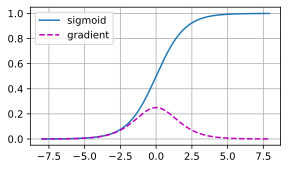

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

- 如上图所示，当sigmoid函数的输入很大或是很小时，它的梯度都会消失。
- 此外，当反向传播通过许多层时，除非在此处，**sigmoid函数的输入接近于零，否则整个乘积的梯度可能会消失**。
- 当网络有很多层时，除非很小心，否则在某一层可能会切断梯度。
- 事实上，这个问题曾经困扰着深度网络的训练。
- 因此，更稳定的**ReLU系列函数已经成为从业者的默认选择**。

### 4.8.1.2 梯度爆炸

- 与梯度消失情况后果类似，梯度爆炸同样令人烦恼。
- 此处生成100个高斯随机矩阵，并将之与某个初始矩阵相乘。
- 对于我们选择的尺度（方差$\sigma^2=1$），矩阵乘积发生爆炸。
- 当这种情况是由于深度网络的初始化所导致时，没有机会让梯度下降优化器收敛。

In [3]:
M = torch.normal(0, 1, size=(4,4))
print('一个矩阵 \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))

print('乘以100个矩阵后\n', M)

一个矩阵 
 tensor([[-0.5250, -1.3627, -0.0115, -1.0586],
        [ 0.9633, -0.2865, -1.1822, -0.7170],
        [-0.1139, -0.8802, -0.7454,  0.7791],
        [ 0.4590, -0.1439,  1.7033,  2.1720]])
乘以100个矩阵后
 tensor([[-9.7798e+24, -3.1863e+24,  1.0709e+25, -7.2619e+24],
        [ 5.6997e+24,  1.8571e+24, -6.2414e+24,  4.2323e+24],
        [ 8.9724e+24,  2.9233e+24, -9.8250e+24,  6.6624e+24],
        [-1.8088e+24, -5.8932e+23,  1.9806e+24, -1.3431e+24]])


### 4.8.1.3 打破对称性

神经网络设计中的另一个问题是其参数化所固有的**对称性**。
假设我们有一个简单的多层感知机，它有一个隐藏层和两个隐藏单元。
在这种情况下，我们可以对第一层的权重$\mathbf{W}^{(1)}$进行重排列，
并且同样对输出层的权重进行重排列，可以获得相同的函数。
第一个隐藏单元与第二个隐藏单元没有什么特别的区别。
换句话说，我们在每一层的隐藏单元之间具有排列对称性。

假设输出层将上述两个隐藏单元的多层感知机转换为仅一个输出单元。
想象一下，如果我们将隐藏层的所有参数初始化为$\mathbf{W}^{(1)} = c$，
$c$为常量，会发生什么？
在这种情况下，在前向传播期间，两个隐藏单元采用相同的输入和参数，
产生相同的激活，该激活被送到输出单元。
在反向传播期间，根据参数$\mathbf{W}^{(1)}$对输出单元进行微分，
得到一个梯度，其元素都取相同的值。
因此，在基于梯度的迭代（例如，小批量随机梯度下降）之后，
$\mathbf{W}^{(1)}$的所有元素仍然采用相同的值。
这样的迭代永远不会打破对称性，我们可能永远也无法实现网络的表达能力。
隐藏层的行为就好像只有一个单元。
请注意，虽然小批量随机梯度下降不会打破这种对称性，但暂退法正则化可以。

- **要点：**
  - 神经网络设计中存在对称性问题，即在每一层的隐藏单元之间具有**排列对称性**。
  - 这种对称性意味着我们可以对第一层的权重进行重排列，并且同样对输出层的权重进行重排列，仍然可以获得相同的函数。
    - 以一个简单的多层感知机（MLP）为例，它具有一个输入层、一个隐藏层和一个输出层。假设隐藏层有两个神经元A和B。现在，我们将隐藏层中神经元A和B的位置交换，同时也交换与这两个神经元相连的权重。在这种情况下，尽管神经元和权重的排列发生了变化，但网络的整体功能和输出仍然保持不变。这就是排列对称性的一个例子。
  - 当隐藏层的所有参数初始化为相同的常数值时，前向传播期间产生的激活相同，这导致反向传播计算的梯度也具有相同的值。
  - 基于梯度的迭代（如小批量随机梯度下降）无法打破这种对称性，从而限制了网络的表达能力。在这种情况下，隐藏层的行为好像只有一个单元。
  - 尽管小批量随机梯度下降无法打破对称性，但权重衰减正则化可以帮助解决这个问题。

## 4.8.2 参数初始化

- 解决（或至少减轻）上述问题的一种方法是进行**参数初始化**，优化期间适当的正则化也可以进一步提高稳定性。

### 4.8.2.1 默认初始化

- 在前面的部分中，例如在3.3节中，使用正态分布来初始化权重值。
- 如果不指定初始化方法，框架将使用默认的随机初始化方法，对于**中等难度**的问题，这种方法通常很有效。
- Pytorch默认的随机初始化方法是**均匀分布**。

### 4.8.2.2 Xavier初始化

让我们看看某些**没有非线性**的全连接层输出（例如，隐藏变量）$o_{i}$的尺度分布。
对于该层$n_\mathrm{in}$输入$x_j$及其相关权重$w_{ij}$，输出由下式给出：

$$o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j. \tag{4.8.3}$$

权重$w_{ij}$都是从同一分布中独立抽取的。
此外，让我们假设该分布具有零均值和方差$\sigma^2$。
请注意，这**并不意味着分布必须是高斯的，只是均值和方差需要存在**。
现在，让我们假设层$x_j$的输入也具有零均值和方差$\gamma^2$，
并且它们独立于$w_{ij}$并且彼此独立。
在这种情况下，我们可以按如下方式计算$o_i$的平均值和方差：

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] \\&= 0, \\
    \mathrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\mathrm{in} \sigma^2 \gamma^2.
\end{aligned} \tag{4.8.4}
$$

**保持输出$o_i$方差不变的一种方法是设置$n_\mathrm{in} \sigma^2 = 1$。**
现在考虑反向传播过程，我们面临着类似的问题，尽管梯度是从更靠近输出的层传播的。
使用与前向传播相同的推断，我们可以看到，除非$n_\mathrm{out} \sigma^2 = 1$，
否则梯度的方差可能会增大，其中$n_\mathrm{out}$是该层的输出的数量。
这使得我们进退两难：我们不可能同时满足这两个条件。
相反，可以找到一个**折中方案**，比如满足：

$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ 或等价于 }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}. 
\end{aligned} \tag{4.8.5}
$$

这就是现在标准且实用的**Xavier初始化**的基础。
通常，Xavier初始化从均值为零，方差
$\sigma^2 = \frac{2}{n_\mathrm{in} + n_\mathrm{out}}$
的高斯分布中采样权重。

我们也可以利用Xavier的直觉来选择从均匀分布中抽取权重时的方差。
注意均匀分布$U(-a, a)$的方差为$\frac{a^2}{3}$。
将$\frac{a^2}{3}$代入到$\sigma^2$的条件中，将得到初始化值域：

$$U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right). \tag{4.8.6}$$

尽管在上述数学推理中，“不存在非线性”的假设在神经网络中很容易被违反，
但Xavier初始化方法在实践中被证明是有效的。

- **要点：**
  - 全连接层输出（隐藏变量）$o_i$ 的计算公式为：$$o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j.$$

  - 假设权重 $w_{ij}$ 和输入 $x_j$ 都独立且具有零均值和方差，分别为 $\sigma^2$ 和 $\gamma^2$。

  - 计算得出 $o_i$ 的平均值和方差分别为 0 和 $n_\mathrm{in} \sigma^2 \gamma^2$。

  - 为了保持方差不变，设置 $n_\mathrm{in} \sigma^2 = 1$。在反向传播过程中，类似地设置 $n_\mathrm{out} \sigma^2 = 1$。

  - 由于无法同时满足这两个条件，我们选择满足 $$\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}$$ 来平衡前向和反向传播时的方差。

  - Xavier 初始化通常从均值为零，方差为 $\sigma^2 = \frac{2}{n_\mathrm{in} + n_\mathrm{out}}$ 的高斯分布中采样权重。

  - 对于均匀分布，初始化权重的范围可以设置为 $$U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right).$$

  - 尽管 Xavier 初始化的推导依赖于“不存在非线性”的假设，在实际应用中，Xavier 初始化被证明是有效的。

----------

- **说明：**
- **(1)神经网络参数化中的对称性问题以及限制神经网络哪些方面的表达能力？**
  - 为了说明神经网络参数化中的对称性问题，本例创建一个简单的两层神经网络（输入层和隐藏层），其中隐藏层具有两个隐藏单元。
  - 在这个示例中，将使用相同的权重初始化所有参数，并通过前向传播和反向传播来观察梯度如何保持相同。
  - 我们可以看到，在前向传播过程中，两个隐藏单元具有相同的输入和参数，因此产生相同的激活值。在反向传播期间，由于输入相同，计算出的梯度也保持相同。因此，这种对称性限制了网络的表达能力，并且基于梯度的迭代方法无法打破这种对称性。具体如下：
    - 在这里，我们使用相同的常数值`c` 初始化隐藏层权重矩阵`W1`的所有元素。
    - 由于 `W1` 的每一行都是相同的，这导致了参数化中的对称性问题。
    - 由于 `W1` 的对称性，前向传播过程中计算得到的 `z1` 和`h` 也具有相同的值。
    - 在反向传播过程中，计算得到的梯度 `dL_dW1` 同样保持对称。这种对称性**限制了神经网络的表达能力**，并使基于梯度的迭代方法无法打破这种对称性。

In [4]:
import numpy as np

# 定义激活函数及其导数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# 输入数据
X = np.array([[0.5, 0.3, 0.7]]).T  # 形状：(3, 1)

# 初始化权重
c = 0.5
W1 = np.full((2, 3), c)  # 隐藏层权重，形状：(2, 3)

# 前向传播
z1 = np.dot(W1, X)       # z1 = W1 * X，形状：(2, 1)
h = sigmoid(z1)          # h = sigmoid(z1)，形状：(2, 1)

print("z1:", z1)
print("h:", h)

# 反向传播
dL_dh = np.ones((2, 1))  # 损失函数关于隐藏层激活值的偏导数（模拟）
dh_dz1 = sigmoid_derivative(z1)  # 隐藏层激活值关于 z1 的偏导数，形状：(2, 1)
dL_dz1 = dL_dh * dh_dz1  # 损失函数关于 z1 的偏导数，形状：(2, 1)

dL_dW1 = np.dot(dL_dz1, X.T)  # 损失函数关于 W1 的偏导数，形状：(2, 3)

print("dL_dW1:", dL_dW1)


z1: [[0.75]
 [0.75]]
h: [[0.6791787]
 [0.6791787]]
dL_dW1: [[0.1089475 0.0653685 0.1525265]
 [0.1089475 0.0653685 0.1525265]]


- 对称性限制了神经网络在学习不同特征方面的表达能力：
  - 当隐藏层的神经元具有相同的权重时，它们都将对输入数据产生相同的响应，并且无法捕捉到输入数据中独立或互补的信息。
  - 例如，在分类问题中，这可能导致神经网络无法识别来自不同类别的样本之间的差异。


- **(2)何为捕捉激活函数前输出值尺度分布的关键特征？**
  - 下述代码首先定义了一个简单的全连接层和 Xavier 初始化方法。
  - 然后，我们生成了一些随机输入数据，并使用 Xavier 初始化方法初始化权重。
  - 接下来，我们计算全连接层的输出（未经过非线性激活函数处理），并绘制输出值的直方图。
  - 从直方图中可以观察到，即使在没有应用非线性激活函数的情况下，全连接层输出值的尺度分布也相对稳定。
  - 这表明 Xavier 初始化方法能够捕捉到激活函数前输出值尺度分布的关键特征，有助于在神经网络的训练过程中**保持信号尺度的稳定性**。


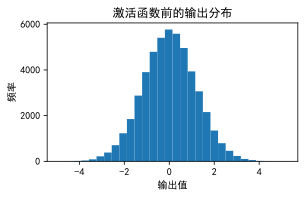

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 定义一个简单的全连接层
def fully_connected_layer(inputs, weights):
    return np.dot(inputs, weights)

# 定义Xavier初始化方法
def xavier_initializer(input_dim, output_dim):
    sigma = np.sqrt(2 / (input_dim + output_dim))
    return np.random.normal(0, sigma, (input_dim, output_dim))

# 设置输入数据和网络参数
input_dim = 100
output_dim = 50
n_samples = 1000

# 生成随机输入数据，均值为0，方差为1
inputs = np.random.normal(0, 1, (n_samples, input_dim))

# 使用Xavier初始化权重
weights = xavier_initializer(input_dim, output_dim)

# 计算全连接层的输出（激活函数前）
outputs = fully_connected_layer(inputs, weights)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为 SimHei（黑体）
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题
# 绘制输出值的直方图
plt.hist(outputs.flatten(), bins=30)
plt.title("激活函数前的输出分布")
plt.xlabel("输出值")
plt.ylabel("频率")
plt.show()


- **(3)神经网络对权重进行初始化时为何要保持方差不变？**
  - 在神经网络训练过程中，保持权重初始化后的方差不变有助于防止信号在传播过程中发生退化（梯度消失或梯度爆炸问题）。这些问题可能导致网络在训练过程中收敛速度变慢或无法收敛。
  - 对权重进行初始化时，希望前向传播和反向传播过程中的信号能够在各层间正常传递。为了达到这个目标，需要确保：
    - 在前向传播过程中，每一层的输出（未经激活函数处理）具有相近的尺度分布。
    - 在反向传播过程中，每一层的梯度具有相近的尺度分布。
    - 保持方差不变是实现上述两个目标的关键。通过控制权重初始值的方差，我们可以使得信号在传播过程中的尺度保持稳定。这样，在训练过程中，梯度可以更有效地传播，从而提高神经网络的性能和收敛速度。
  - Xavier 初始化方法就是基于这个原理设计的。它**根据输入节点和输出节点的数量动态调整权重初始值的方差，以平衡前向传播和反向传播过程中的尺度分布**。这种初始化方法在实践中被证明是有效的，有助于提高神经网络的训练效果。
---------------------

## 小结

* 梯度消失和梯度爆炸是深度网络中常见的问题。在参数初始化时需要非常小心，以确保梯度和参数可以得到很好的控制。
* 需要用启发式的初始化方法来确保初始梯度既不太大也不太小。
* ReLU激活函数缓解了梯度消失问题，这样可以加速收敛。
* 随机初始化是保证在进行优化前打破对称性的关键。
* Xavier初始化表明，对于每一层，输出的方差不受输入数量的影响，任何梯度的方差不受输出数量的影响。

